In [79]:
import pandas as pd
%matplotlib inline
%run Pipeline//upload_and_vizualize 
%run Pipeline//classify_and_evaluate 
%run Pipeline//aux
%run Pipeline//ULAB_ML_Pipeline
%run Pipeline//processing
%run Pipeline//cleaning
%run Pipeline//magicloops.py

In [29]:
## CONFIG DATA ##
START_DATE= '2007/01/01'
END_DATE = '2016/12/31'
fac_id = 'PGM_SYS_ID'

VIOLATION = 'violation'
INSPECTION = 'inspection'
STACKTEST = 'stacktest'
TITLEV = 'titlev'
FORMALACT = 'formalact'
INFORMALACT = 'informalact'


### DON'T FORGET TO CHANGE THE DATA_FILE!!! ###
df_dict ={'violation': {'data_file': 'ICIS-AIR_downloads/ICIS-AIR_VIOLATION_HISTORY.csv',
                        'interest_var': ['AGENCY_TYPE_DESC','AIR_LCON_CODE','ENF_RESPONSE_POLICY_CODE','POLLUTANT_CODES','PROGRAM_CODES','HPV_RESOLVED_DATE'],
                         'date_col': 'HPV_DAYZERO_DATE',
                       'date_format':'%m-%d-%Y'},
          
           'inspection': {'data_file': 'ICIS-AIR_downloads/ICIS-AIR_FCES_PCES.csv',
                          'interest_var': ['STATE_EPA_FLAG','COMP_MONITOR_TYPE_CODE','PROGRAM_CODES'],
                          'date_col': 'ACTUAL_END_DATE',
                          'date_format':'%m-%d-%Y'},
          
           'stacktest': {'data_file':'ICIS-AIR_downloads/ICIS-AIR_STACK_TESTS.csv',
                         'interest_var':['COMP_MONITOR_TYPE_CODE','POLLUTANT_CODES','AIR_STACK_TEST_STATUS_CODE'],
                        'date_col': 'ACTUAL_END_DATE',
                        'date_format':'%m/%d/%Y'},
          
           'titlev':{'data_file': 'ICIS-AIR_downloads/ICIS-AIR_TITLEV_CERTS.csv',
                     'interest_var':['COMP_MONITOR_TYPE_CODE','FACILITY_RPT_DEVIATION_FLAG'],
                        'date_col': 'ACTUAL_END_DATE',
                    'date_format':'%m/%d/%Y'},
          
           'formalact':{'data_file': 'ICIS-AIR_downloads/ICIS-AIR_FORMAL_ACTIONS.csv',
                       'interest_var':['ENF_TYPE_CODE','PENALTY_AMOUNT'],
                        'date_col': 'SETTLEMENT_ENTERED_DATE',
                       'date_format':'%m/%d/%Y'},
          
           'informalact':{'data_file': 'ICIS-AIR_downloads/ICIS-AIR_INFORMAL_ACTIONS.csv',
                          'interest_var':['ENF_TYPE_CODE'],
                        'date_col': 'ACHIEVED_DATE',
                         'date_format':'%m/%d/%Y'}}

In [30]:
years = list(range(2006,2016))  #the years are inclusive (the last year will be the ultimate test year and not included in model generation)

In [57]:
#year_list = train_test_dates(years)
year_list = [{'test': '2015', 'train': [('2012', '2014')]},{'test': '2014','train': [('2011', '2013')]}]
models_to_run = ['RF', 'LR', 'ET','AB','GB','NB','DT','SVM','KNN']
clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
        'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
        'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
        'LR': LogisticRegression(penalty='l1', C=1e5),
        'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
        'NB': GaussianNB(),
        'DT': DecisionTreeClassifier(),
        'SGD': SGDClassifier(loss="hinge", penalty="l2"),
        'KNN': KNeighborsClassifier(n_neighbors=3)
            }
test_grid = {
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'SGD': { 'loss': ['perceptron'], 'penalty': ['l2']},
    'ET': { 'n_estimators': [1], 'criterion' : ['gini'] ,'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}
           }


In [32]:
#output_df = run_loops(year_list,models_to_run,clfs,test_grid)

In [33]:
master_feature = generate_features('2006','2016')
master_label = generate_label('2006','2016')
merged = pd.merge(master_feature.dropna(), master_label, how='inner', left_on=['PGM_SYS_ID','HPV_DAYZERO_DATE_year'], right_on = ['PGM_SYS_ID','ACTUAL_END_DATE_year'])
        
#merged = pd.merge(master_feature, master_label, how='inner', left_on=['PGM_SYS_ID','HPV_DAYZERO_DATE_year'], right_on = ['PGM_SYS_ID','ACTUAL_END_DATE_year'])
#run for each set of train-test years
#master_feature = merged.drop('Outcome',axis=1)
#master_label = merged[['Outcome']]

In [34]:
test_grid = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'SGD': { 'loss': ['perceptron'], 'penalty': ['l2']},
    'ET': { 'n_estimators': [1], 'criterion' : ['gini'] ,'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}
           }

In [64]:
def clf_loop(models_to_run, clfs, grid, X_train, X_test, y_train, y_test, train_test_year, specification):
    '''
    Run different models with different classifiers
    Input:
    - models_to_run: a list of models to run
    - clfs: base classifiers
    - X_train, X_test, y_train, y_test: divided data
    - specification: whether data were standardized, imbalanced sampled
    Output: a dataframe of evaluating the different classifiers
    '''
    results_df =  pd.DataFrame(columns=('Model','Classifier', 'Parameters', 'AUC-ROC', 'Accuracy', 'Prec@5', 'Prec@10', 'Prec@20',
                                       'Rec@5', 'Rec@10','Rec@20', 'F@5', 'F@10', 'F@20'))

    for index,clf in enumerate([clfs[x] for x in models_to_run]):
        print (models_to_run[index] + specification)
        parameter_values = grid[models_to_run[index]]
        for p in ParameterGrid(parameter_values):
            try:
                clf.set_params(**p)
                y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)#[:1]
                y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                
                accuracy = clf.score(X_test, y_test)
                roc = roc_auc_score(y_test, y_pred_probs)
                p5, r5, f5 = evaluate_at_k(y_test_sorted,y_pred_probs_sorted, 5.0)
                p10, r10, f10 = evaluate_at_k(y_test_sorted,y_pred_probs_sorted, 10.0)
                p20, r20, f20 = evaluate_at_k(y_test_sorted,y_pred_probs_sorted, 20.0)
                
                results_df.loc[len(results_df)] = [train_test_year + models_to_run[index] + specification, clf, p, roc, accuracy,                                               
                                                   p5, p10, p20, r5, r10, r20, f5, f10, f20]

                if NOTEBOOK == 1:
                    plot_precision_recall_n(y_test,y_pred_probs,clf)
            except IndexError as e:
                print ('Error:',e)
                continue
    return results_df


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using 

RF_Stand_UndSamp


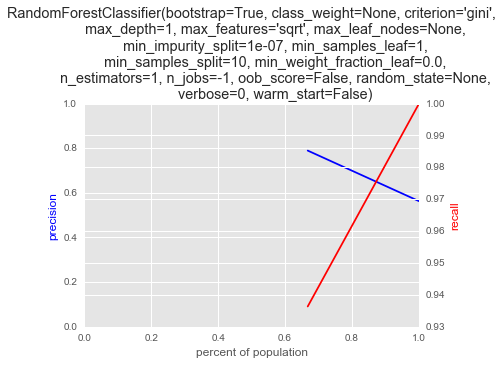

LR_Stand_UndSamp


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


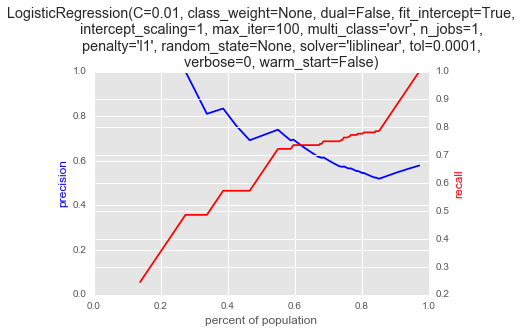

ET_Stand_UndSamp


/Users/andrewyaspan/Documents/ml_project/ML_Project/Pipeline/magicloops.py:247: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]


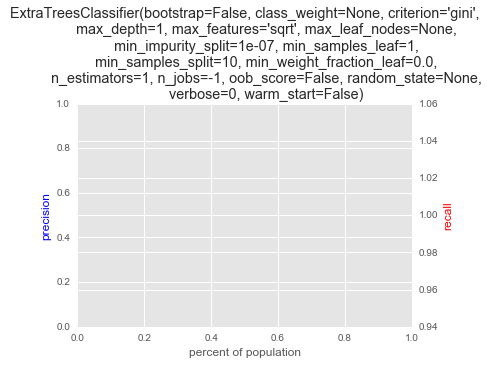

AB_Stand_UndSamp


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


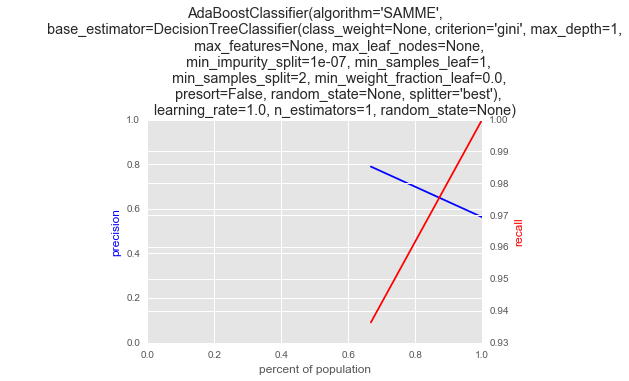

GB_Stand_UndSamp


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


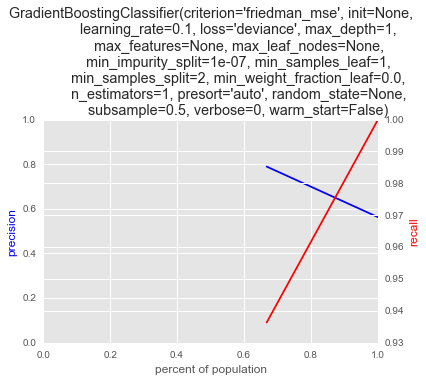

NB_Stand_UndSamp


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


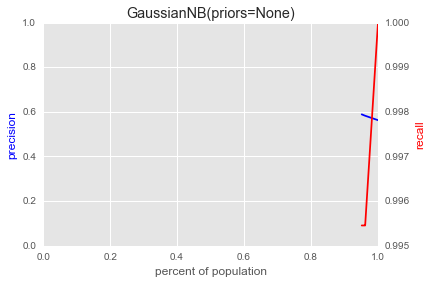

DT_Stand_UndSamp


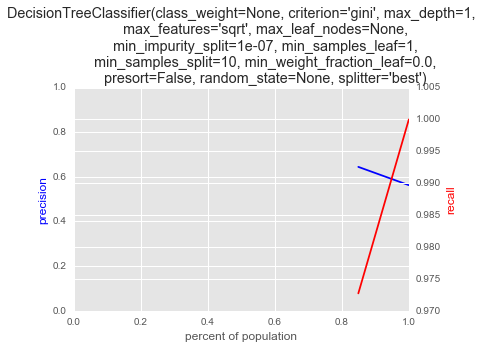

SVM_Stand_UndSamp


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


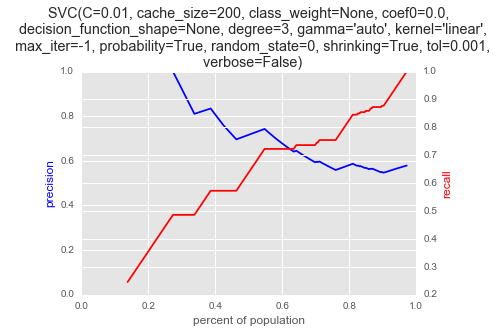

KNN_Stand_UndSamp


/Users/andrewyaspan/Documents/ml_project/ML_Project/Pipeline/magicloops.py:247: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]


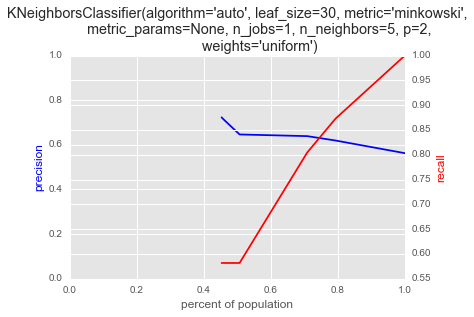

/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using 

RF_Stand_UndSamp


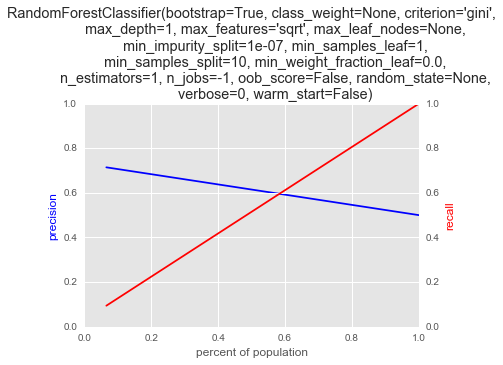

LR_Stand_UndSamp


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


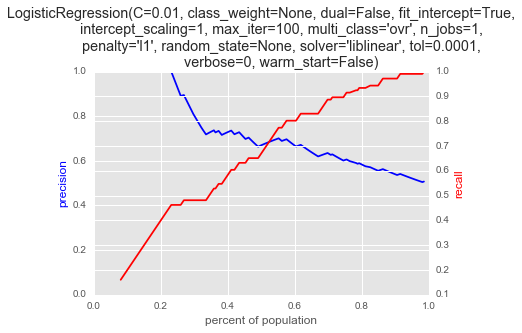

ET_Stand_UndSamp


/Users/andrewyaspan/Documents/ml_project/ML_Project/Pipeline/magicloops.py:247: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]


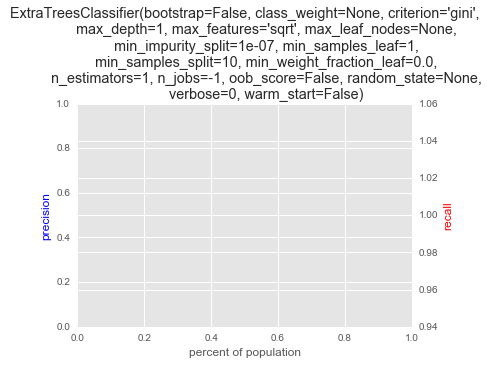

AB_Stand_UndSamp


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


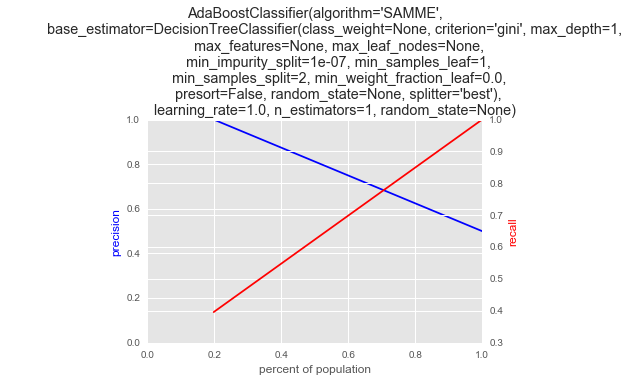

GB_Stand_UndSamp


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


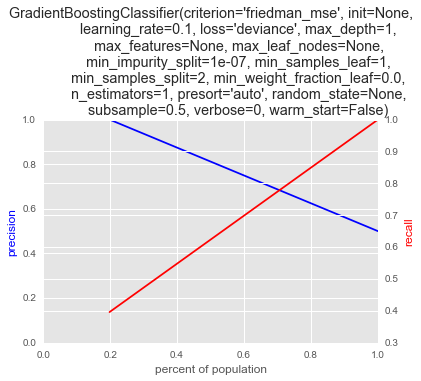

NB_Stand_UndSamp


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


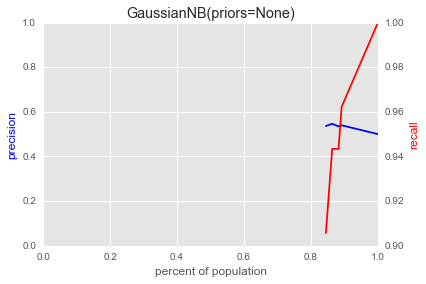

DT_Stand_UndSamp


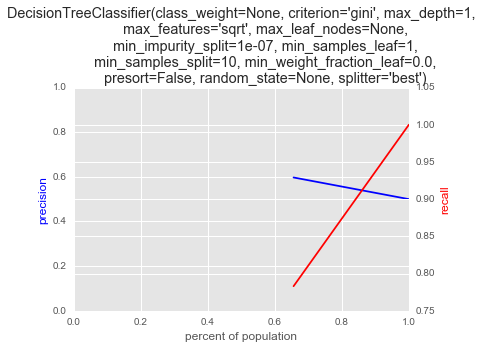

SVM_Stand_UndSamp


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


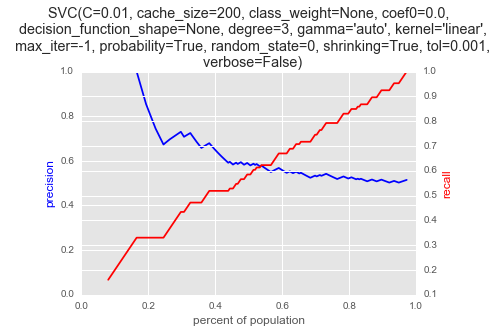

KNN_Stand_UndSamp


/Users/andrewyaspan/Documents/ml_project/ML_Project/Pipeline/magicloops.py:247: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]


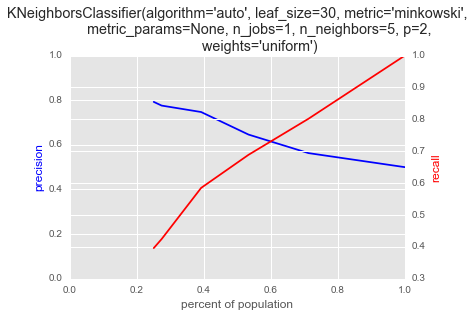

In [72]:
merged = merged.dropna()
grid = test_grid
final_df = pd.DataFrame()
for each_set in year_list:

    #Get train and test sets
    start_date = each_set['train'][0][0]
    end_date = each_set['train'][0][1]
    test_date = each_set['test']
    YEAR = 'HPV_DAYZERO_DATE_year'

    training = merged[merged[YEAR]>= start_date]
    training = training[training[YEAR] <= end_date]
    testing = merged[merged[YEAR] == test_date]

    X_train = training.iloc[:,2:].drop('Outcome', axis = 1)
    y_train = training[['Outcome']]

    X_test = testing.iloc[:,2:].drop('Outcome', axis = 1)
    y_test = testing[['Outcome']]
    
    #print(X_train.head(), y_train.head(),X_test.head(), y_test.head())
    #X_train = master_feature[master_feature[YEAR] >= start_date]
    #X_train = X_train[X_train[YEAR] <= end_date]

    #X_test = master_feature[master_feature[YEAR] == test_date]

    #y_train = master_label[master_label[YEAR] >= start_date]
    #y_train = y_train[y_train[YEAR] <= end_date]

    #y_test = master_label[master_label[YEAR] == test_date]

    #run once standardized (continuous variables) and once with undersampling + standarization
    specifications = ['_Standardized', '_Stand_UndSamp']
    specification = specifications[n]
    train_test_year = 'TR:' + str(start_date) + '-' + str(end_date) + '&TS:' + str(test_date) + '_'
    # standardize
    X_train_st, X_test_st = transform(X_train, X_test)  #Need to hardcode continuous variables
    results_df_1 = clf_loop(models_to_run, clfs, grid, X_train_st, X_test_st, y_train, y_test, train_test_year, specification)

    final_df = final_df.append(results_df_1)

    #print('Took ', (time.time() - start_time), ' seconds to run models')
    #return final_df

In [ ]:
merged.PENALTY_AMOUNT

In [80]:
result_df = run_loops(year_list, models_to_run, clfs, grid)

KeyError: 'ACTUAL_END_DATE_year'

In [76]:
master_feature.head()

,PGM_SYS_ID,HPV_DAYZERO_DATE_year,COMP_MONITOR_TYPE_CODE_TVA,FACILITY_RPT_DEVIATION_FLAG,AGENCY_TYPE_DESC_Local,AGENCY_TYPE_DESC_State,AGENCY_TYPE_DESC_U.S. EPA,AIR_LCON_CODE_ACH,AIR_LCON_CODE_AVA,AIR_LCON_CODE_BAA,...,ENF_TYPE_CODE_SCAAAO,PENALTY_AMOUNT,ENF_TYPE_CODE_DAWL,ENF_TYPE_CODE_IRL,ENF_TYPE_CODE_LOVWL,ENF_TYPE_CODE_LRE,ENF_TYPE_CODE_NONC,ENF_TYPE_CODE_NOV,ENF_TYPE_CODE_SCL,NonInspection_HPV_Count
0,AK0000000201300005,2016,5,0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,AK0000000201600009,2011,20,0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,AK0000000209000007,2012,15,0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1
3,AK0000000212200033,2008,10,0,0.0,1.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,AK0000000212200033,2008,10,0,0.0,1.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [81]:
final_df

,Model,Classifier,Parameters,AUC-ROC,Accuracy,Prec@5,Prec@10,Prec@20,Rec@5,Rec@10,Rec@20,F@5,F@10,F@20
0,TR:2012-2014&TS:2015_RF_Stand_UndSamp,"(DecisionTreeClassifier(class_weight=None, cri...","{'n_estimators': 1, 'min_samples_split': 10, '...",0.807363,0.823529,1.0,1.000000,1.000000,0.086364,0.177273,0.354545,0.158996,0.301158,0.523490
1,TR:2012-2014&TS:2015_LR_Stand_UndSamp,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",0.696212,0.662404,1.0,1.000000,1.000000,0.086364,0.177273,0.354545,0.158996,0.301158,0.523490
2,TR:2012-2014&TS:2015_ET_Stand_UndSamp,"(ExtraTreeClassifier(class_weight=None, criter...","{'n_estimators': 1, 'min_samples_split': 10, '...",0.500000,0.437340,1.0,1.000000,1.000000,0.086364,0.177273,0.354545,0.158996,0.301158,0.523490
3,TR:2012-2014&TS:2015_AB_Stand_UndSamp,"(DecisionTreeClassifier(class_weight=None, cri...","{'n_estimators': 1, 'algorithm': 'SAMME'}",0.807363,0.823529,1.0,1.000000,1.000000,0.086364,0.177273,0.354545,0.158996,0.301158,0.523490
4,TR:2012-2014&TS:2015_GB_Stand_UndSamp,([DecisionTreeRegressor(criterion='friedman_ms...,"{'n_estimators': 1, 'learning_rate': 0.1, 'sub...",0.807363,0.437340,1.0,1.000000,1.000000,0.086364,0.177273,0.354545,0.158996,0.301158,0.523490
5,TR:2012-2014&TS:2015_NB_Stand_UndSamp,GaussianNB(priors=None),{},0.550306,0.606138,1.0,1.000000,1.000000,0.086364,0.177273,0.354545,0.158996,0.301158,0.523490
6,TR:2012-2014&TS:2015_DT_Stand_UndSamp,"DecisionTreeClassifier(class_weight=None, crit...","{'min_samples_split': 10, 'criterion': 'gini',...",0.641334,0.437340,1.0,1.000000,1.000000,0.086364,0.177273,0.354545,0.158996,0.301158,0.523490
7,TR:2012-2014&TS:2015_SVM_Stand_UndSamp,"SVC(C=0.01, cache_size=200, class_weight=None,...","{'kernel': 'linear', 'C': 0.01}",0.708666,0.616368,1.0,1.000000,1.000000,0.086364,0.177273,0.354545,0.158996,0.301158,0.523490
8,TR:2012-2014&TS:2015_KNN_Stand_UndSamp,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'weights': 'uniform', 'algorithm': 'auto', 'n...",0.654918,0.585678,1.0,1.000000,1.000000,0.086364,0.177273,0.354545,0.158996,0.301158,0.523490
0,TR:2011-2013&TS:2014_RF_Stand_UndSamp,"(DecisionTreeClassifier(class_weight=None, cri...","{'n_estimators': 1, 'min_samples_split': 10, '...",0.528302,0.528302,1.0,0.809524,0.904762,0.094340,0.160377,0.358491,0.172414,0.267717,0.513514
